In [14]:
import numpy as np
import itertools
import random
import scipy as sc
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm_notebook
import time
%matplotlib inline

In [96]:
def path_weight(A, K, path):
    result = 0
    prev = path[0]
    for cur in path:
        result += get_linear_path_weight(A, prev, cur, K)
        prev = cur
    return result

In [15]:
def get_matrix_P(field, locations_lib, N, K, max_path_len = 10):
    P_weight = np.zeros((N**2,N**2)) + 10**4
    for ids in tqdm_notebook(itertools.product(np.arange(0,N**2), repeat=2)):
        p_start = locations_lib[ids[0]]
        p_end = locations_lib[ids[1]]
        if np.sqrt((p_end[0]-p_start[0])**2 + (p_end[1]-p_start[1])**2) <= max_path_len:
            path_weight = get_linear_path_weight(field, p_start, p_end, K)
            P_weight[ids[0], ids[1]] = path_weight
    return P_weight
def get_linear_path_weight(field, start, end, K, max_path_len = 10):
    dist_weight = np.sqrt((end[0]-start[0])**2 + (end[1]-start[1])**2)
    crush_weight = path_crushing_score(field, start, end)
    path_weight = dist_weight + K*crush_weight 
    return path_weight
def path_crushing_score(field, start, end):
    xx1 = np.linspace(start[0], end[0] - 0.1, 100)
    yy1 = np.linspace(start[1] + 0.1, end[1], 100)
    xx2 = np.linspace(start[0] + 0.1, end[0], 100)
    yy2 = np.linspace(start[1], end[1] - 0.1, 100)
    xx = np.concatenate((xx1, xx2))
    yy = np.concatenate((yy1, yy2))
    states = np.unique(np.column_stack((xx, yy)).round().astype(int), axis=0)[1:].T
    score = field[states[0], states[1]].sum()
    return score

In [16]:
# def get_linear_path_weight(field, x_start, y_start, x_end, y_end, K):
#     dist_weight = np.sqrt((x_end-x_start)**2 + (y_end-y_start)**2)
#     crush_weight = path_crushing_score(field, x_start, y_start, x_end, y_end)
#     path_weight = dist_weight + K*crush_weight 
#     return path_weight

In [17]:
# def get_matrix_P(field, locations_lib, N, K):
#     f_get_linear_path_weight = lambda x_start, y_start, x_end, y_end: get_linear_path_weight(field, x_start, y_start, x_end, y_end, K)
#     f_arr = np.frompyfunc(f_get_linear_path_weight, 4, 1)
#     all_path = np.array([np.concatenate([locations_lib[p1], locations_lib[p2]]) for p1 in np.arange(0,N**2)
#                          for p2 in np.arange(0,N**2)]) 
#     P_weight = f_arr(all_path[:,0],all_path[:,1], all_path[:,2], all_path[:,3]).reshape((N**2, N**2))
#     return P_weight

In [18]:
def get_opt_path_matrix(N, G_weight, path_matrix, P_weight, locations_lib, step_count):
    for i in tqdm_notebook(range(step_count)):
        loc_sample = random.sample(set(np.arange(0,N**2)),k=1)[0]
        upd_path_id = np.where(G_weight > P_weight[:, loc_sample] + G_weight[loc_sample])[0]
        G_weight[upd_path_id] = P_weight[upd_path_id, loc_sample] + G_weight[loc_sample]
        upd_loc_id = locations_lib[upd_path_id].T
        path_matrix[upd_loc_id[0], upd_loc_id[1]] = loc_sample
    return path_matrix

In [19]:
def path_finding(field, start, end, K, step_count=1000):
    
    #размер поля
    N = np.shape(field)[0]
    
    #библиотека состояний дронов (позиций в пространсве)
    locations_lib = np.array([[x,y] for x in np.arange(0,N) for y in np.arange(0,N)]) #мб лучше tuple
    
    #получение id начального и конечного состояний
    start_id = np.where(np.all(locations_lib==start,axis=1))[0][0]
    end_id = np.where(np.all(locations_lib==end,axis=1))[0][0]
    
    #матрица весов прямых путей
    start_time = time.time()
    print('Generating linear path weight matrix...')
    P_weight = get_matrix_P(field, locations_lib, N, K)
    end_time = time.time()
    print('\rTime spend {} sec'.format(round(end_time-start_time)))
    
    #Получение матрицы оптимальных путей
    path_matrix = np.zeros((N,N), dtype=int) + end_id
    path_matrix[end[0],end[1]] = -1
    G_weight = P_weight[:,end_id]
    path_matrix = get_opt_path_matrix(N, G_weight, path_matrix, P_weight, locations_lib, step_count)
    
    #получение по-координатного пути
    loc = start
    path = [start]
    while loc != end:
        link_loc_id = path_matrix[loc[0],loc[1]]
        loc = list(locations_lib[link_loc_id])
        path += [loc]
    path = np.array(path)
    
    return path

In [20]:
def generateField(n, m):
    A = np.zeros((n,n))
    loc_barrier = []
    sigm = sts.uniform(loc=1, scale=2.5)
    for i in tqdm_notebook(range(m)):
        x = np.random.choice(range(A.shape[0]))
        y = np.random.choice(range(A.shape[1]))
        sigm_x = sigm.rvs()
        sigm_y = sigm.rvs()
        A += generateProb2Crush(A.shape[0], x, y, sigm_x, sigm_y)
        loc_barrier.append(np.array([x, y, sigm_x, sigm_y, False]))
    
    field_max = A.max()
    A /= field_max
    return A, loc_barrier, field_max

In [21]:
def updateField(me, visible_field, radius, barriers, field_max):
    flag = False
    for barrier in barriers:
        if np.linalg.norm(me - barrier[:2]) < radius and not barrier[4]:
            flag = True
            visible_field += generateProb2Crush(visible_field.shape[0], 
                                                barrier[0], barrier[1], barrier[2], barrier[3]) / field_max
            barrier[4] = True
   
    return flag

In [22]:
def generateProb2Crush(n, x, y, sigm_x, sigm_y):
    A = np.zeros((n, n))
    rv_x = sts.norm(loc=x + 0.5, scale=sigm_x)
    rv_y = sts.norm(loc=y + 0.5, scale=sigm_y)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            A[i][j] += (rv_x.cdf(i + 1) - rv_x.cdf(i)) * (rv_y.cdf(j + 1) - rv_y.cdf(j))
    return A
    # create 2d norm distr.

In [196]:
def plotField(A, path):
    X = range(A.shape[0]+1)
    Y = range(A.shape[1]+1)
    fig = plt.figure(figsize=(14, 12))
    pcm = plt.pcolormesh(X, Y, A,
                           norm=colors.Normalize(vmin=-1, vmax=1),
                           cmap='RdBu', edgecolors='white')
    plt.colorbar(pcm, extend='both')
    plt.plot(0.5 + path[:,1], 0.5 + path[:,0], 'r', linestyle='-.')
    for i,point in enumerate(path):
        plt.annotate(str(i), (point[1] + 0.25, point[0] + 0.25))
    plt.show()

In [24]:
def dynimic_path_finding(A, loc_barrier, field_max, visible_radius, start, end, K, step_count):
    final_path = np.array([start])
    visible_field = np.zeros((A.shape[0], A.shape[1]))
    updateField(np.array(start), visible_field, visible_radius, loc_barrier, field_max)

    find = True
    while find:
        path = path_finding(visible_field, start, end, K, step_count=step_count)
        path_points = []
        for i in range(len(path)-1):
            linear_start = path[i]
            linear_end = path[i+1]
            step_len = max(abs(linear_start[0] - linear_end[0]), abs(linear_start[1] - linear_end[1])) + 1
            xx = np.linspace(linear_start[0], linear_end[0], 2 * step_len)
            yy = np.linspace(linear_start[1], linear_end[1], 2 * step_len)
            path_points += [np.column_stack((xx, yy))]

        find = False

        for lin_path in range(len(path_points)):
            for loc in path_points[lin_path]:
                if updateField(loc, visible_field, visible_radius, loc_barrier, field_max):
                    print('Alert! Find barrier!')
                    new_start_loc = loc.round().astype(int)
                    prev_path = np.vstack((path[:lin_path+1], new_start_loc))
                    start = list(new_start_loc)
                    find = True
                    break
            if find:
                break

        if find:
            final_path = np.vstack((final_path, prev_path))
        else: 
            final_path = np.vstack((final_path, path))
    return final_path

In [25]:
loc_barrier = np.array([([27.        ,  8.        ,  2.10387032,  1.42010863,  1.        ]),
 ([19.        , 16.        ,  3.45277781,  3.44785605,  1.        ]),
 ([27.        ,  4.        ,  1.73680321,  2.85224524,  1.        ]),
 ([0.        , 9.        , 2.98862286, 1.74539626, 1.        ]),
 ([ 0.        , 14.        ,  3.04158126,  3.49829752,  1.        ]),
 ([22.        , 26.        ,  1.1895243 ,  3.32500847,  1.        ]),
 ([ 7.        , 29.        ,  2.26190712,  2.25101839,  1.        ]),
 ([2.        , 7.        , 2.39015502, 2.3225454 , 1.        ]),
 ([ 7.        , 26.        ,  2.18457534,  2.80883817,  1.        ]),
 ([25.        , 23.        ,  2.95252999,  1.15912848,  1.        ]),
 ([18.        , 28.        ,  2.79499306,  1.38486838,  1.        ]),
 ([ 4.        , 21.        ,  2.56252399,  1.96037905,  1.        ]),
 ([28.        , 18.        ,  1.58891271,  3.41505301,  1.        ]),
 ([17.        ,  5.        ,  3.44785792,  3.46362332,  1.        ]),
 ([23.        , 15.        ,  2.07978895,  1.18310176,  1.        ]),
 ([14.        , 24.        ,  3.00651155,  2.08294911,  1.        ]),
 ([19.        , 20.        ,  3.27998175,  1.61771702,  1.        ]),
 ([8.        , 2.        , 1.93144702, 1.80165272, 1.        ]),
 ([22.        , 22.        ,  3.25534814,  2.68326972,  1.        ]),
 ([26.        , 11.        ,  2.44491238,  2.52641854,  1.        ])])

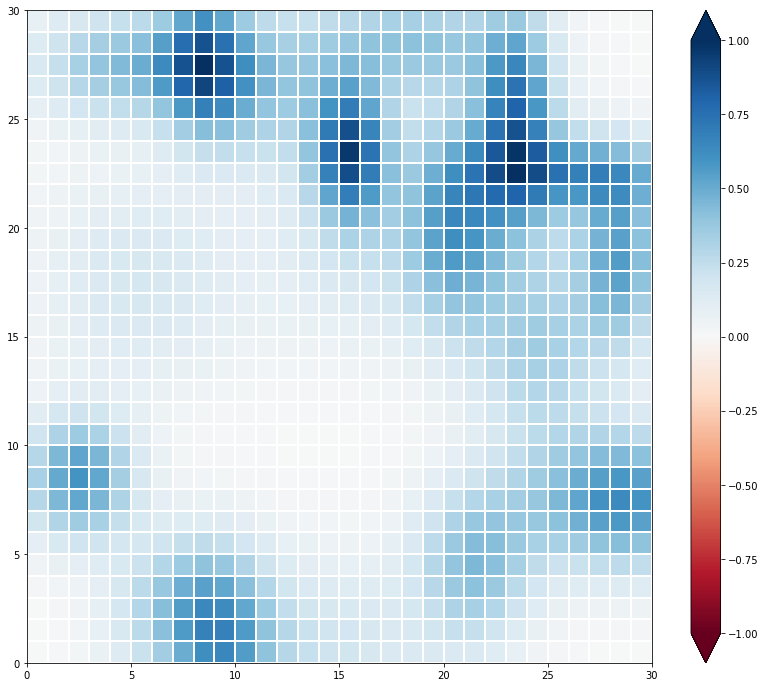

In [26]:
# A, loc_barrier, field_max = generateField(30, 20)
n = 30
A = np.zeros((n,n))
for i in tqdm_notebook(loc_barrier):
    x = i[0]
    y = i[1]
    sigm_x = i[2]
    sigm_y = i[3]
    A += generateProb2Crush(A.shape[0], x, y, sigm_x, sigm_y)
field_max = A.max()
A /= field_max
plotField(A, np.array([[1,1],[1,1]]))

Generating linear path weight matrix...
Time spend 149.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 148.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 147.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 148.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 148.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 147.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 147.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 150.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 148.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 148.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 147.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 147.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 147.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 147.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 148.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 148.0 sec



Alert! Find barrier!
Generating linear path weight matrix...
Time spend 147.0 sec


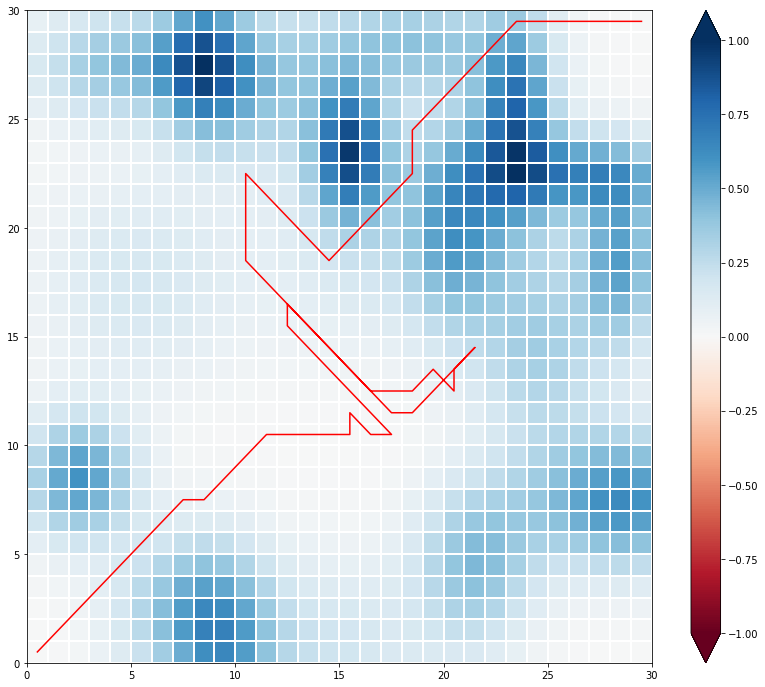

In [44]:
visible_radius = 10
start  = [0,0]
end = [29,29]
K = 40
step_count = 10**4 

path = dynimic_path_finding(A, loc_barrier, field_max, visible_radius, start, end, K, step_count)
plotField(A, path)

In [46]:
loc_barrier

[array([27.        ,  8.        ,  2.10387032,  1.42010863,  1.        ]),
 array([19.        , 16.        ,  3.45277781,  3.44785605,  1.        ]),
 array([27.        ,  4.        ,  1.73680321,  2.85224524,  1.        ]),
 array([0.        , 9.        , 2.98862286, 1.74539626, 1.        ]),
 array([ 0.        , 14.        ,  3.04158126,  3.49829752,  1.        ]),
 array([22.        , 26.        ,  1.1895243 ,  3.32500847,  1.        ]),
 array([ 7.        , 29.        ,  2.26190712,  2.25101839,  1.        ]),
 array([2.        , 7.        , 2.39015502, 2.3225454 , 1.        ]),
 array([ 7.        , 26.        ,  2.18457534,  2.80883817,  1.        ]),
 array([25.        , 23.        ,  2.95252999,  1.15912848,  1.        ]),
 array([18.        , 28.        ,  2.79499306,  1.38486838,  1.        ]),
 array([ 4.        , 21.        ,  2.56252399,  1.96037905,  1.        ]),
 array([28.        , 18.        ,  1.58891271,  3.41505301,  1.        ]),
 array([17.        ,  5.        ,  

In [24]:
# A, loc_barrier, field_max = generateField(30, 15)
start  = [0,0]
end = [29,29]
step_count = 10**5

K_arr = np.array([1, 4, 7, 10, 13, 16, 19, 22, 100])
radius_K = np.array([10 , 100])

radius_arr = np.array([1, 4, 7, 10, 13, 16, 19, 22, 100])
K_radius = np.array([5, 100])

results_K = []
results_radius = []

# plotField(A, path)
for K in K_arr:
    for radius in radius_K:
        path = dynimic_path_finding(A, loc_barrier, field_max, radius, start, end, K, step_count)
        for barrier in loc_barrier:
            barrier[4] = False
        results_K.append([K, radius, path])
        print("K = " + str(K) + "\tradius =" + str(radius) + "\tpath :\n" + str(path))

for radius in radius_arr:
    for K in K_radius:
        path = dynimic_path_finding(A, loc_barrier, field_max, radius, start, end, K, step_count)
        for barrier in loc_barrier:
            barrier[4] = False
        results_radius.append([K, radius, path])
        print("K = " + str(K) + "\tradius =" + str(radius) + "\tpath :\n" + str(path))

Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 1	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [11 11]
 [11 11]
 [12 13]
 [12 13]
 [12 14]
 [12 14]
 [13 16]
 [13 16]
 [14 17]
 [14 17]
 [15 19]
 [15 19]
 [15 19]
 [15 19]
 [16 20]
 [16 20]
 [18 24]
 [20 25]
 [22 26]
 [22 26]
 [23 26]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



K = 1	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 4  3]
 [ 7  7]
 [ 8  9]
 [12 16]
 [16 22]
 [20 25]
 [25 27]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 4	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [10 10]
 [11 11]
 [11 11]
 [11 14]
 [11 14]
 [11 14]
 [11 14]
 [11 15]
 [11 15]
 [13 15]
 [13 15]
 [13 15]
 [14 17]
 [14 17]
 [14 19]
 [14 19]
 [14 20]
 [14 20]
 [14 20]
 [15 22]
 [15 22]
 [15 22]
 [20 26]
 [22 26]
 [22 26]
 [23 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



K = 4	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 5  4]
 [ 8  8]
 [11 16]
 [13 20]
 [15 23]
 [18 25]
 [20 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 7	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [10 11]
 [10 11]
 [10 13]
 [10 13]
 [10 15]
 [10 15]
 [10 15]
 [10 15]
 [10 17]
 [10 17]
 [11 20]
 [11 20]
 [11 21]
 [11 21]
 [12 21]
 [12 21]
 [13 22]
 [13 22]
 [13 20]
 [13 18]
 [13 18]
 [13 18]
 [13 17]
 [13 16]
 [14 14]
 [16 12]
 [16 12]
 [18 12]
 [18 12]
 [19 12]
 [20 12]
 [20 12]
 [20 15]
 [20 15]
 [20 17]
 [24 18]
 [27 20]
 [29 21]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



K = 7	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 4  3]
 [ 8  8]
 [11 16]
 [12 18]
 [13 20]
 [15 23]
 [18 25]
 [20 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 10	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [ 9  9]
 [10 11]
 [10 11]
 [10 11]
 [10 13]
 [10 13]
 [10 14]
 [10 15]
 [10 15]
 [10 15]
 [10 15]
 [10 17]
 [10 17]
 [11 16]
 [13 14]
 [13 14]
 [16 11]
 [16 11]
 [16 11]
 [13 14]
 [12 15]
 [11 17]
 [11 20]
 [11 20]
 [11 21]
 [11 21]
 [12 21]
 [12 21]
 [13 22]
 [13 22]
 [15 23]
 [15 23]
 [15 23]
 [18 25]
 [20 26]
 [22 26]
 [22 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



K = 10	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 4  3]
 [ 8  8]
 [11 16]
 [13 20]
 [15 23]
 [18 25]
 [20 26]
 [22 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 13	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [ 9  9]
 [10 11]
 [10 11]
 [10 11]
 [10 13]
 [10 13]
 [10 14]
 [10 15]
 [10 15]
 [10 15]
 [10 15]
 [10 17]
 [10 17]
 [11 15]
 [14 12]
 [14 12]
 [16 11]
 [16 11]
 [16 11]
 [15 11]
 [12 14]
 [11 16]
 [11 18]
 [11 20]
 [11 20]
 [11 21]
 [11 21]
 [12 21]
 [12 21]
 [13 22]
 [13 22]
 [15 23]
 [15 23]
 [15 23]
 [18 25]
 [20 26]
 [22 26]
 [22 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 48.0 sec



K = 13	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 4  3]
 [ 8  8]
 [ 9 10]
 [10 14]
 [12 19]
 [14 22]
 [18 25]
 [20 26]
 [21 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



K = 16	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [ 9  9]
 [10 11]
 [10 11]
 [10 11]
 [10 13]
 [10 13]
 [10 15]
 [10 15]
 [10 15]
 [10 15]
 [10 17]
 [10 17]
 [11 15]
 [14 12]
 [14 12]
 [16 11]
 [16 11]
 [16 11]
 [15 11]
 [12 14]
 [11 16]
 [11 17]
 [11 20]
 [11 20]
 [11 21]
 [11 21]
 [12 21]
 [12 21]
 [13 22]
 [13 22]
 [14 22]
 [15 23]
 [15 23]
 [18 25]
 [20 26]
 [22 26]
 [22 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 48.0 sec



K = 16	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 5  4]
 [ 8  8]
 [ 9 10]
 [10 14]
 [11 20]
 [11 21]
 [11 25]
 [12 29]
 [21 29]
 [29 29]]
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 19	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 3  2]
 [ 5  5]
 [ 7  6]
 [ 7  6]
 [ 9  9]
 [10 11]
 [10 11]
 [10 11]
 [10 13]
 [10 13]
 [10 15]
 [10 15]
 [10 15]
 [10 15]
 [10 17]
 [10 17]
 [10 16]
 [11 14]
 [14 11]
 [14 11]
 [15 11]
 [16 11]
 [16 11]
 [15 11]
 [12 14]
 [11 16]
 [11 20]
 [11 20]
 [11 21]
 [11 21]
 [12 21]
 [12 21]
 [13 22]
 [13 22]
 [13 20]
 [13 18]
 [14 18]
 [17 18]
 [17 18]
 [18 18]
 [18 18]
 [24 18]
 [27 20]
 [29 20]
 [29 26]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



K = 19	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 5  4]
 [ 8  8]
 [ 9 10]
 [10 14]
 [11 20]
 [11 25]
 [12 29]
 [15 29]
 [18 29]
 [24 29]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 22	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 3  2]
 [ 5  5]
 [ 7  6]
 [ 7  6]
 [ 9  9]
 [10 11]
 [10 11]
 [10 11]
 [10 13]
 [10 13]
 [10 15]
 [10 15]
 [10 15]
 [10 15]
 [10 17]
 [10 17]
 [10 16]
 [11 14]
 [14 11]
 [14 11]
 [16 11]
 [16 11]
 [14 11]
 [11 14]
 [11 19]
 [11 20]
 [11 20]
 [11 21]
 [11 21]
 [12 21]
 [12 21]
 [13 22]
 [13 22]
 [13 18]
 [14 18]
 [17 18]
 [17 18]
 [18 18]
 [18 18]
 [24 18]
 [27 20]
 [29 20]
 [29 27]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



K = 22	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 5  4]
 [ 9  9]
 [10 15]
 [11 19]
 [11 20]
 [11 25]
 [12 29]
 [15 29]
 [20 29]
 [21 29]
 [24 29]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 100	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 1  0]
 [ 3  1]
 [ 5  5]
 [ 7  6]
 [ 7  6]
 [ 9  9]
 [ 9 10]
 [ 9 10]
 [ 9 11]
 [10 13]
 [10 13]
 [10 13]
 [10 13]
 [10 14]
 [10 15]
 [10 15]
 [10 16]
 [10 16]
 [10 16]
 [10 16]
 [10 14]
 [13 11]
 [14 11]
 [14 11]
 [15 11]
 [16 11]
 [16 11]
 [15 11]
 [14 11]
 [11 11]
 [11 12]
 [11 15]
 [11 20]
 [11 20]
 [11 21]
 [11 21]
 [12 21]
 [12 21]
 [11 15]
 [11 10]
 [11  6]
 [12  6]
 [12  3]
 [15  0]
 [18  0]
 [18  0]
 [20  0]
 [21  0]
 [21  0]
 [22  0]
 [22  2]
 [22  3]
 [22  4]
 [22  5]
 [22  7]
 [22 10]
 [22 10]
 [22 12]
 [25 12]
 [25 13]
 [25 13]
 [29 13]
 [29 19]
 [29 19]
 [29 20]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



K = 100	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 1  0]
 [ 3  1]
 [ 4  3]
 [ 9  9]
 [ 9 12]
 [10 16]
 [11 18]
 [11 20]
 [11 27]
 [12 29]
 [14 29]
 [15 29]
 [22 29]
 [25 29]
 [29 29]]


NameError: name 'radius_arr' is not defined

In [ ]:
start  = [0,0]
end = [29,29]
step_count = 10**5

radius_arr = np.array([1, 4, 7, 10, 13, 16, 19, 22, 100])
K_radius = np.array([5, 100])

for radius in radius_arr:
    for K in K_radius:
        path = dynimic_path_finding(A, loc_barrier, field_max, radius, start, end, K, step_count)
        for barrier in loc_barrier:
            barrier[4] = False
        results_radius.append([K, radius, path])
        print("K = " + str(K) + "\tradius =" + str(radius) + "\tpath :\n" + str(path))

Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



K = 5	radius =1	path :
[[ 0  0]
 [ 0  0]
 [ 1  1]
 [ 2  2]
 [ 3  3]
 [ 4  4]
 [ 5  5]
 [ 6  6]
 [ 7  7]
 [10 10]
 [13 13]
 [16 16]
 [19 19]
 [19 19]
 [19 19]
 [19 22]
 [20 24]
 [22 25]
 [22 25]
 [24 25]
 [29 29]]
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 100	radius =1	path :
[[ 0  0]
 [ 0  0]
 [ 1  1]
 [ 2  2]
 [ 3  3]
 [ 4  4]
 [ 5  5]
 [ 6  6]
 [ 7  7]
 [10 10]
 [13 13]
 [16 16]
 [19 19]
 [19 19]
 [19 19]
 [22 15]
 [22 15]
 [22 14]
 [27  8]
 [27  8]
 [27  9]
 [27 10]
 [27 11]
 [29 14]
 [29 15]
 [29 22]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 51.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 5	radius =4	path :
[[ 0  0]
 [ 0  0]
 [ 1  1]
 [ 2  2]
 [ 3  3]
 [ 3  3]
 [ 3  3]
 [ 4  3]
 [ 4  3]
 [ 4  3]
 [ 9  9]
 [14 14]
 [15 15]
 [15 15]
 [15 19]
 [15 19]
 [15 19]
 [15 20]
 [15 20]
 [16 22]
 [18 23]
 [18 23]
 [18 24]
 [18 24]
 [18 24]
 [18 24]
 [18 24]
 [20 25]
 [22 25]
 [22 25]
 [23 25]
 [25 26]
 [29 29]]
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



K = 100	radius =4	path :
[[ 0  0]
 [ 0  0]
 [ 1  1]
 [ 2  2]
 [ 3  3]
 [ 3  3]
 [ 3  3]
 [ 4  2]
 [ 4  2]
 [ 4  3]
 [ 6  6]
 [ 9  8]
 [15 13]
 [16 14]
 [16 14]
 [13 14]
 [11 14]
 [10 15]
 [10 22]
 [11 23]
 [11 23]
 [10 23]
 [10 23]
 [10 23]
 [10 21]
 [ 9 13]
 [ 9 12]
 [10 10]
 [13  7]
 [13  7]
 [13  7]
 [13 10]
 [14 10]
 [15 10]
 [22 10]
 [22 10]
 [22 11]
 [22 11]
 [22  7]
 [24  5]
 [24  5]
 [24  5]
 [24  5]
 [22  5]
 [19  8]
 [16 11]
 [15 11]
 [11 11]
 [11 17]
 [12 19]
 [13 19]
 [15 20]
 [15 20]
 [15 26]
 [15 26]
 [15 25]
 [18 25]
 [18 25]
 [19 24]
 [19 24]
 [21 24]
 [21 24]
 [21 25]
 [23 25]
 [25 26]
 [29 29]]
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



K = 5	radius =7	path :
[[ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 1  0]
 [ 4  3]
 [ 4  3]
 [ 9  9]
 [13 13]
 [13 13]
 [13 16]
 [13 16]
 [13 16]
 [13 17]
 [13 17]
 [15 16]
 [16 16]
 [16 16]
 [18 17]
 [18 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 19]
 [21 19]
 [24 19]
 [26 20]
 [26 25]
 [29 29]]
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...


In [15]:
start  = [0,0]
end = [29,29]
step_count = 10**5

results_radius = []

radius_arr = np.array([7, 10, 13, 16, 19, 22, 100])
K_radius = np.array([5, 100])

for radius in radius_arr:
    for K in K_radius:
        path = dynimic_path_finding(A, loc_barrier, field_max, radius, start, end, K, step_count)
        for barrier in loc_barrier:
            barrier[4] = False
        results_radius.append([K, radius, path])
        print("K = " + str(K) + "\tradius =" + str(radius) + "\tpath :\n" + str(path))

Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



K = 5	radius =7	path :
[[ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 1  0]
 [ 4  3]
 [ 4  3]
 [ 9  9]
 [13 13]
 [13 13]
 [13 16]
 [13 16]
 [13 16]
 [13 17]
 [13 17]
 [15 16]
 [16 16]
 [16 16]
 [18 17]
 [18 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 18]
 [21 19]
 [21 19]
 [25 19]
 [26 21]
 [26 25]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



K = 100	radius =7	path :
[[ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 1  0]
 [ 3  1]
 [ 4  3]
 [ 5  4]
 [ 5  4]
 [ 6  6]
 [ 8  7]
 [14 12]
 [14 12]
 [12 12]
 [11 12]
 [10 13]
 [ 9 15]
 [ 9 16]
 [ 9 16]
 [10 18]
 [10 18]
 [10 16]
 [10 15]
 [10 13]
 [10 11]
 [11  9]
 [11  9]
 [11  9]
 [11 10]
 [18 10]
 [18 10]
 [19 10]
 [19 10]
 [19 10]
 [14 10]
 [13 10]
 [10 13]
 [10 15]
 [10 17]
 [10 20]
 [10 20]
 [12 20]
 [12 20]
 [12 24]
 [12 24]
 [12 24]
 [12 24]
 [15 24]
 [15 24]
 [18 24]
 [18 24]
 [19 26]
 [25 26]
 [29 29]]
Generating linear path weight matrix...



Time spend 52.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 57.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



K = 5	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [10 10]
 [11 11]
 [11 11]
 [11 13]
 [11 14]
 [11 14]
 [11 14]
 [11 14]
 [11 15]
 [11 15]
 [13 15]
 [13 15]
 [13 15]
 [13 16]
 [13 17]
 [13 17]
 [12 18]
 [12 18]
 [12 20]
 [12 20]
 [14 21]
 [14 21]
 [15 22]
 [15 22]
 [20 26]
 [22 26]
 [22 26]
 [23 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 54.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 50.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



K = 100	radius =10	path :
[[ 0  0]
 [ 0  0]
 [ 1  0]
 [ 3  1]
 [ 5  5]
 [ 7  6]
 [ 7  6]
 [ 9  9]
 [ 9 10]
 [ 9 10]
 [ 9 11]
 [10 13]
 [10 13]
 [10 13]
 [10 13]
 [10 14]
 [10 15]
 [10 15]
 [10 16]
 [10 16]
 [10 16]
 [10 16]
 [10 14]
 [13 11]
 [14 11]
 [14 11]
 [15 11]
 [16 11]
 [16 11]
 [15 11]
 [14 11]
 [11 11]
 [11 13]
 [11 14]
 [11 15]
 [11 20]
 [11 20]
 [11 21]
 [11 21]
 [12 21]
 [12 21]
 [11 15]
 [11 10]
 [11  6]
 [12  6]
 [12  3]
 [15  0]
 [18  0]
 [18  0]
 [19  0]
 [21  0]
 [21  0]
 [22  0]
 [22  2]
 [22  3]
 [22  4]
 [22  5]
 [22  9]
 [22 10]
 [22 10]
 [22 12]
 [25 12]
 [25 13]
 [25 13]
 [29 13]
 [29 19]
 [29 19]
 [29 23]
 [29 25]
 [29 26]
 [29 29]]
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 50.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 45.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



K = 5	radius =13	path :
[[ 0  0]
 [ 0  0]
 [ 1  1]
 [ 1  1]
 [ 4  4]
 [ 4  4]
 [ 7  6]
 [ 9  8]
 [ 9  8]
 [ 9  9]
 [ 9  9]
 [10 11]
 [10 11]
 [10 12]
 [10 12]
 [10 12]
 [10 12]
 [10 14]
 [10 14]
 [11 16]
 [11 16]
 [11 17]
 [11 17]
 [11 17]
 [11 17]
 [14 14]
 [14 14]
 [15 15]
 [15 15]
 [15 15]
 [15 15]
 [15 16]
 [15 19]
 [15 20]
 [15 21]
 [17 24]
 [20 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 50.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 53.0 sec



K = 100	radius =13	path :
[[ 0  0]
 [ 0  0]
 [ 1  0]
 [ 3  1]
 [ 3  1]
 [ 3  1]
 [ 4  3]
 [ 4  3]
 [ 4  3]
 [ 9  9]
 [ 9  9]
 [ 9  9]
 [ 9  9]
 [ 9 12]
 [ 9 12]
 [ 9 13]
 [ 9 13]
 [11 11]
 [11 11]
 [12 11]
 [13 11]
 [13 11]
 [11 11]
 [11 13]
 [11 14]
 [11 15]
 [11 15]
 [11 15]
 [11 17]
 [11 17]
 [11 17]
 [11 17]
 [11 14]
 [11  6]
 [12  6]
 [12  3]
 [15  0]
 [15  0]
 [17  0]
 [17  0]
 [20  0]
 [22  0]
 [22  3]
 [22  4]
 [22  5]
 [22  7]
 [22  7]
 [21  7]
 [18 10]
 [14 10]
 [11 13]
 [11 14]
 [12 19]
 [12 19]
 [12 17]
 [14 17]
 [14 17]
 [12 17]
 [12 18]
 [12 22]
 [12 29]
 [17 29]
 [25 29]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 50.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 51.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



K = 5	radius =16	path :
[[ 0  0]
 [ 0  0]
 [ 2  2]
 [ 2  2]
 [ 6  5]
 [ 6  5]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [ 8  8]
 [ 8  8]
 [ 8  8]
 [ 8  9]
 [ 8  9]
 [ 8  9]
 [ 8  9]
 [10 10]
 [10 10]
 [10 10]
 [10 10]
 [10 11]
 [10 11]
 [10 13]
 [10 13]
 [10 13]
 [10 14]
 [10 14]
 [11 15]
 [11 15]
 [11 15]
 [11 15]
 [12 16]
 [12 16]
 [13 20]
 [15 23]
 [18 25]
 [20 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 51.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 50.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 51.0 sec



K = 100	radius =16	path :
[[ 0  0]
 [ 0  0]
 [ 1  0]
 [ 2  0]
 [ 2  0]
 [ 4  3]
 [ 6  5]
 [ 6  5]
 [ 7  6]
 [ 7  6]
 [ 8  8]
 [ 8  8]
 [ 9  8]
 [ 9  8]
 [ 9  9]
 [ 9  9]
 [ 9 10]
 [ 9 10]
 [ 9 10]
 [10 10]
 [10 10]
 [10 12]
 [10 12]
 [10 13]
 [10 13]
 [10 13]
 [10 14]
 [10 14]
 [10 10]
 [10  9]
 [11  8]
 [11  6]
 [11  6]
 [11  6]
 [11 12]
 [13 12]
 [13 12]
 [13 12]
 [12 13]
 [12 14]
 [12 14]
 [12 24]
 [12 29]
 [17 29]
 [26 29]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 5	radius =19	path :
[[ 0  0]
 [ 0  0]
 [ 3  2]
 [ 3  2]
 [ 5  4]
 [ 5  4]
 [ 7  6]
 [ 7  6]
 [ 7  6]
 [ 7  6]
 [ 8  7]
 [ 8  7]
 [ 8  7]
 [ 8  7]
 [ 9  8]
 [ 9  8]
 [ 9  8]
 [ 9  8]
 [ 9 10]
 [ 9 10]
 [ 9 11]
 [ 9 11]
 [10 12]
 [10 12]
 [10 12]
 [10 12]
 [11 16]
 [13 20]
 [15 23]
 [18 25]
 [20 26]
 [23 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 51.0 sec



K = 100	radius =19	path :
[[ 0  0]
 [ 0  0]
 [ 1  0]
 [ 3  1]
 [ 4  2]
 [ 4  2]
 [ 4  3]
 [ 5  4]
 [ 5  4]
 [ 6  6]
 [ 6  6]
 [ 7  7]
 [ 7  7]
 [ 7  7]
 [ 7  7]
 [ 8  7]
 [ 8  7]
 [ 8  7]
 [ 8  8]
 [ 8  8]
 [ 9  8]
 [ 9  8]
 [ 9  8]
 [ 9 10]
 [ 9 10]
 [ 9 11]
 [ 9 11]
 [ 9 11]
 [10 12]
 [10 12]
 [10 13]
 [11 21]
 [11 23]
 [11 26]
 [11 27]
 [12 29]
 [16 29]
 [19 29]
 [22 29]
 [24 29]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 47.0 sec



K = 5	radius =22	path :
[[ 0  0]
 [ 0  0]
 [ 2  2]
 [ 2  2]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 7  7]
 [ 7  7]
 [ 7  7]
 [ 7  7]
 [ 8  9]
 [ 8  9]
 [ 8  9]
 [ 8  9]
 [ 8  9]
 [ 8  9]
 [10 14]
 [13 20]
 [15 23]
 [18 25]
 [20 26]
 [21 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 47.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 50.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 50.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 49.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 48.0 sec



Alert! Find barrier!
Generating linear path weight matrix...



Time spend 46.0 sec



K = 100	radius =22	path :
[[ 0  0]
 [ 0  0]
 [ 1  0]
 [ 3  1]
 [ 3  1]
 [ 4  3]
 [ 4  3]
 [ 4  3]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 5  4]
 [ 7  6]
 [ 7  6]
 [ 8  7]
 [ 8  7]
 [ 9  8]
 [ 9  8]
 [ 9  8]
 [ 9  8]
 [ 9  8]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [ 9 11]
 [ 9 13]
 [10 15]
 [11 19]
 [11 20]
 [11 21]
 [11 23]
 [11 26]
 [11 27]
 [12 29]
 [17 29]
 [26 29]
 [29 29]]
Generating linear path weight matrix...



Time spend 46.0 sec



K = 5	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 4  3]
 [ 8  8]
 [11 16]
 [13 20]
 [15 23]
 [18 25]
 [20 26]
 [21 26]
 [24 26]
 [27 28]
 [29 29]]
Generating linear path weight matrix...



Time spend 46.0 sec



K = 100	radius =100	path :
[[ 0  0]
 [ 0  0]
 [ 1  0]
 [ 3  1]
 [ 4  3]
 [ 9  9]
 [ 9 12]
 [10 16]
 [11 18]
 [11 20]
 [11 28]
 [13 29]
 [16 29]
 [17 29]
 [26 29]
 [29 29]]


In [34]:
log_K = [[1, 10, [[0, 0], [0, 0], [6, 5], [7, 6], [7, 6], [11, 11], [11, 11], [12, 13], [12, 13], [12, 14], [12, 14], [13, 16], [13, 16], [14, 17], [14, 17], [15, 19], [15, 19], [15, 19], [15, 19], [16, 20], [16, 20], [18, 24], [20, 25], [22, 26], [22, 26], [23, 26], [29, 29]]],
[1, 100, [[0, 0], [0, 0], [4, 3], [7, 7], [8, 9], [12, 16], [16, 22], [20, 25], [25, 27], [27, 28], [29, 29]]],
[4, 10, [[0, 0], [0, 0], [6, 5], [7, 6], [7, 6], [10, 10], [11, 11], [11, 11], [11, 14], [11, 14], [11, 14], [11, 14], [11, 15], [11, 15], [13, 15], [13, 15], [13, 15], [14, 17], [14, 17], [14, 19], [14, 19], [14, 20], [14, 20], [14, 20], [15, 22], [15, 22], [15, 22], [20, 26], [22, 26], [22, 26], [23, 26], [24, 26], [27, 28], [29, 29]]],

[4, 100, [[0, 0], [0, 0], [5, 4], [8, 8], [11, 16], [13, 20], [15, 23], [18, 25], [20, 26], [24, 26], [27, 28], [29, 29]]],

[7, 10, [[0, 0], [0, 0], [6, 5], [7, 6], [7, 6], [10, 11], [10, 11], [10, 13], [10, 13], [10, 15], [10, 15], [10, 15], [10, 15], [10, 17], [10, 17], [11, 20], [11, 20], [11, 21], [11, 21], [12, 21], [12, 21], [13, 22], [13, 22], [13, 20], [13, 18], [13, 18], [13, 18], [13, 17], [13, 16], [14, 14], [16, 12], [16, 12], [18, 12], [18, 12], [19, 12], [20, 12], [20, 12], [20, 15], [20, 15], [20, 17], [24, 18], [27, 20], [29, 21], [29, 29]]],

[7, 100, [[0, 0], [0, 0], [4, 3], [8, 8], [11, 16], [12, 18], [13, 20], [15, 23], [18, 25], [20, 26], [24, 26], [27, 28], [29, 29]]],

[10, 10, [[0, 0], [0, 0], [6, 5], [7, 6], [7, 6], [9, 9], [10, 11], [10, 11], [10, 11], [10, 13], [10, 13], [10, 14], [10, 15], [10, 15], [10, 15], [10, 15], [10, 17], [10, 17], [11, 16], [13, 14], [13, 14], [16, 11], [16, 11], [16, 11], [13, 14], [12, 15], [11, 17], [11, 20], [11, 20], [11, 21], [11, 21], [12, 21], [12, 21], [13, 22], [13, 22], [15, 23], [15, 23], [15, 23], [18, 25], [20, 26], [22, 26], [22, 26], [24, 26], [27, 28], [29, 29]]],

[10, 100, [[0, 0], [0, 0], [4, 3], [8, 8], [11, 16], [13, 20], [15, 23], [18, 25], [20, 26], [22, 26], [24, 26], [27, 28], [29, 29]]],

[13, 10, [[0, 0], [0, 0], [6, 5], [7, 6], [7, 6], [9, 9], [10, 11], [10, 11], [10, 11], [10, 13], [10, 13], [10, 14], [10, 15], [10, 15], [10, 15], [10, 15], [10, 17], [10, 17], [11, 15], [14, 12], [14, 12], [16, 11], [16, 11], [16, 11], [15, 11], [12, 14], [11, 16], [11, 18], [11, 20], [11, 20], [11, 21], [11, 21], [12, 21], [12, 21], [13, 22], [13, 22], [15, 23], [15, 23], [15, 23], [18, 25], [20, 26], [22, 26], [22, 26], [24, 26], [27, 28], [29, 29]]],
[13, 100, [[0, 0], [0, 0], [4, 3], [8, 8], [9, 10], [10, 14], [12, 19], [14, 22], [18, 25], [20, 26], [21, 26], [24, 26], [27, 28], [29, 29]]],

[16, 10, [[0, 0], [0, 0], [6, 5], [7, 6], [7, 6], [9, 9], [10, 11], [10, 11], [10, 11], [10, 13], [10, 13], [10, 15], [10, 15], [10, 15], [10, 15], [10, 17], [10, 17], [11, 15], [14, 12], [14, 12], [16, 11], [16, 11], [16, 11], [15, 11], [12, 14], [11, 16], [11, 17], [11, 20], [11, 20], [11, 21], [11, 21], [12, 21], [12, 21], [13, 22], [13, 22], [14, 22], [15, 23], [15, 23], [18, 25], [20, 26], [22, 26], [22, 26], [24, 26], [27, 28], [29, 29]]],

[16, 100, [[0, 0], [0, 0], [5, 4], [8, 8], [9, 10], [10, 14], [11, 20], [11, 21], [11, 25], [12, 29], [21, 29], [29, 29]]],
[19, 10, [[0, 0], [0, 0], [3, 2], [5, 5], [7, 6], [7, 6], [9, 9], [10, 11], [10, 11], [10, 11], [10, 13], [10, 13], [10, 15], [10, 15], [10, 15], [10, 15], [10, 17], [10, 17], [10, 16], [11, 14], [14, 11], [14, 11], [15, 11], [16, 11], [16, 11], [15, 11], [12, 14], [11, 16], [11, 20], [11, 20], [11, 21], [11, 21], [12, 21], [12, 21], [13, 22], [13, 22], [13, 20], [13, 18], [14, 18], [17, 18], [17, 18], [18, 18], [18, 18], [24, 18], [27, 20], [29, 20], [29, 26], [29, 29]]],

[19, 100, [[0, 0], [0, 0], [5, 4], [8, 8], [9, 10], [10, 14], [11, 20], [11, 25], [12, 29], [15, 29], [18, 29], [24, 29], [29, 29]]],

[22, 10, [[0, 0], [0, 0], [3, 2], [5, 5], [7, 6], [7, 6], [9, 9], [10, 11], [10, 11], [10, 11], [10, 13], [10, 13], [10, 15], [10, 15], [10, 15], [10, 15], [10, 17], [10, 17], [10, 16], [11, 14], [14, 11], [14, 11], [16, 11], [16, 11], [14, 11], [11, 14], [11, 19], [11, 20], [11, 20], [11, 21], [11, 21], [12, 21], [12, 21], [13, 22], [13, 22], [13, 18], [14, 18], [17, 18], [17, 18], [18, 18], [18, 18], [24, 18], [27, 20], [29, 20], [29, 27], [29, 29]]],

[22, 100, [[0, 0], [0, 0], [5, 4], [9, 9], [10, 15], [11, 19], [11, 20], [11, 25], [12, 29], [15, 29], [20, 29], [21, 29], [24, 29], [29, 29]]],

[100, 10, [[0, 0], [0, 0], [1, 0], [3, 1], [5, 5], [7, 6], [7, 6], [9, 9], [9, 10], [9, 10], [9, 11], [10, 13], [10, 13], [10, 13], [10, 13], [10, 14], [10, 15], [10, 15], [10, 16], [10, 16], [10, 16], [10, 16], [10, 14], [13, 11], [14, 11], [14, 11], [15, 11], [16, 11], [16, 11], [15, 11], [14, 11], [11, 11], [11, 12], [11, 15], [11, 20], [11, 20], [11, 21], [11, 21], [12, 21], [12, 21], [11, 15], [11, 10], [11, 6], [12, 6], [12, 3], [15, 0], [18, 0], [18, 0], [20, 0], [21, 0], [21, 0], [22, 0], [22, 2], [22, 3], [22, 4], [22, 5], [22, 7], [22, 10], [22, 10], [22, 12], [25, 12], [25, 13], [25, 13], [29, 13], [29, 19], [29, 19], [29, 20], [29, 29]]],
[100, 100, [[0, 0], [0, 0], [1, 0], [3, 1], [4, 3], [9, 9], [9, 12], [10, 16], [11, 18], [11, 20], [11, 27], [12, 29], [14, 29], [15, 29], [22, 29], [25, 29], [29, 29]]]]

In [41]:
log_K[4]

[7,
 10,
 [[0, 0],
  [0, 0],
  [6, 5],
  [7, 6],
  [7, 6],
  [10, 11],
  [10, 11],
  [10, 13],
  [10, 13],
  [10, 15],
  [10, 15],
  [10, 15],
  [10, 15],
  [10, 17],
  [10, 17],
  [11, 20],
  [11, 20],
  [11, 21],
  [11, 21],
  [12, 21],
  [12, 21],
  [13, 22],
  [13, 22],
  [13, 20],
  [13, 18],
  [13, 18],
  [13, 18],
  [13, 17],
  [13, 16],
  [14, 14],
  [16, 12],
  [16, 12],
  [18, 12],
  [18, 12],
  [19, 12],
  [20, 12],
  [20, 12],
  [20, 15],
  [20, 15],
  [20, 17],
  [24, 18],
  [27, 20],
  [29, 21],
  [29, 29]]]

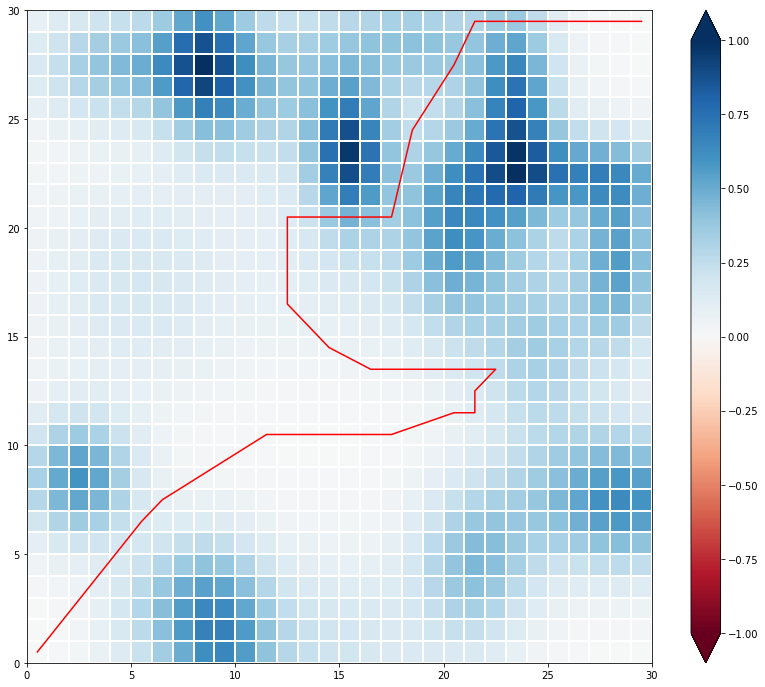

In [40]:
plotField(A, np.array(log_K[4][2]))

In [49]:
log_Radius = [[5, 1, [[0, 0], [0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [10, 10], [13, 13], [16, 16], [19, 19], [19, 19], [19, 19], [19, 22], [20, 24], [22, 25], [22, 25], [24, 25], [29, 29]]], 

[100, 1, [[0, 0], [0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [10, 10], [13, 13], [16, 16], [19, 19], [19, 19], [19, 19], [22, 15], [22, 15], [22, 14], [27, 8], [27, 8], [27, 9], [27, 10], [27, 11], [29, 14], [29, 15], [29, 22], [29, 29]]], 

[5, 4, [[0, 0], [0, 0], [1, 1], [2, 2], [3, 3], [3, 3], [3, 3], [4, 3], [4, 3], [4, 3], [9, 9], [14, 14], [15, 15], [15, 15], [15, 19], [15, 19], [15, 19], [15, 20], [15, 20], [16, 22], [18, 23], [18, 23], [18, 24], [18, 24], [18, 24], [18, 24], [18, 24], [20, 25], [22, 25], [22, 25], [23, 25], [25, 26], [29, 29]]], 

[100, 4, [[0, 0], [0, 0], [1, 1], [2, 2], [3, 3], [3, 3], [3, 3], [4, 2], [4, 2], [4, 3], [6, 6], [9, 8], [15, 13], [16, 14], [16, 14], [13, 14], [11, 14], [10, 15], [10, 22], [11, 23], [11, 23], [10, 23], [10, 23], [10, 23], [10, 21], [9, 13], [9, 12], [10, 10], [13, 7], [13, 7], [13, 7], [13, 10], [14, 10], [15, 10], [22, 10], [22, 10], [22, 11], [22, 11], [22, 7], [24, 5], [24, 5], [24, 5], [24, 5], [22, 5], [19, 8], [16, 11], [15, 11], [11, 11], [11, 17], [12, 19], [13, 19], [15, 20], [15, 20], [15, 26], [15, 26], [15, 25], [18, 25], [18, 25], [19, 24], [19, 24], [21, 24], [21, 24], [21, 25], [23, 25], [25, 26], [29, 29]]], 

[5, 7, [[0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [1, 0], [4, 3], [4, 3], [9, 9], [13, 13], [13, 13], [13, 16], [13, 16], [13, 16], [13, 17], [13, 17], [15, 16], [16, 16], [16, 16], [18, 17], [18, 17], [21, 17], [21, 17], [21, 17], [21, 17], [21, 19], [21, 19], [24, 19], [26, 20], [26, 25], [29, 29]]], 

[100, 7, [[0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [1, 0], [3, 1], [4, 3], [5, 4], [5, 4], [6, 6], [8, 7], [14, 12], [14, 12], [12, 12], [11, 12], [10, 13], [9, 15], [9, 16], [9, 16], [10, 18], [10, 18], [10, 16], [10, 15], [10, 13], [10, 11], [11, 9], [11, 9], [11, 9], [11, 10], [18, 10], [18, 10], [19, 10], [19, 10], [19, 10], [14, 10], [13, 10], [10, 13], [10, 15], [10, 17], [10, 20], [10, 20], [12, 20], [12, 20], [12, 24], [12, 24], [12, 24], [12, 24], [15, 24], [15, 24], [18, 24], [18, 24], [19, 26], [25, 26], [29, 29]]], 

[5, 10, [[0, 0], [0, 0], [6, 5], [7, 6], [7, 6], [10, 10], [11, 11], [11, 11], [11, 13], [11, 14], [11, 14], [11, 14], [11, 14], [11, 15], [11, 15], [13, 15], [13, 15], [13, 15], [13, 16], [13, 17], [13, 17], [12, 18], [12, 18], [12, 20], [12, 20], [14, 21], [14, 21], [15, 22], [15, 22], [20, 26], [22, 26], [22, 26], [23, 26], [24, 26], [27, 28], [29, 29]]], 

[100, 10, [[0, 0], [0, 0], [1, 0], [3, 1], [5, 5], [7, 6], [7, 6], [9, 9], [9, 10], [9, 10], [9, 11], [10, 13], [10, 13], [10, 13], [10, 13], [10, 14], [10, 15], [10, 15], [10, 16], [10, 16], [10, 16], [10, 16], [10, 14], [13, 11], [14, 11], [14, 11], [15, 11], [16, 11], [16, 11], [15, 11], [14, 11], [11, 11], [11, 13], [11, 14], [11, 15], [11, 20], [11, 20], [11, 21], [11, 21], [12, 21], [12, 21], [11, 15], [11, 10], [11, 6], [12, 6], [12, 3], [15, 0], [18, 0], [18, 0], [19, 0], [21, 0], [21, 0], [22, 0], [22, 2], [22, 3], [22, 4], [22, 5], [22, 9], [22, 10], [22, 10], [22, 12], [25, 12], [25, 13], [25, 13], [29, 13], [29, 19], [29, 19], [29, 23], [29, 25], [29, 26], [29, 29]]], 

[5, 13, [[0, 0], [0, 0], [1, 1], [1, 1], [4, 4], [4, 4], [7, 6], [9, 8], [9, 8], [9, 9], [9, 9], [10, 11], [10, 11], [10, 12], [10, 12], [10, 12], [10, 12], [10, 14], [10, 14], [11, 16], [11, 16], [11, 17], [11, 17], [11, 17], [11, 17], [14, 14], [14, 14], [15, 15], [15, 15], [15, 15], [15, 15], [15, 16], [15, 19], [15, 20], [15, 21], [17, 24], [20, 26], [24, 26], [27, 28], [29, 29]]],

[100, 13, [[0, 0], [0, 0], [1, 0], [3, 1], [3, 1], [3, 1], [4, 3], [4, 3], [4, 3], [9, 9], [9, 9], [9, 9], [9, 9], [9, 12], [9, 12], [9, 13], [9, 13], [11, 11], [11, 11], [12, 11], [13, 11], [13, 11], [11, 11], [11, 13], [11, 14], [11, 15], [11, 15], [11, 15], [11, 17], [11, 17], [11, 17], [11, 17], [11, 14], [11, 6], [12, 6], [12, 3], [15, 0], [15, 0], [17, 0], [17, 0], [20, 0], [22, 0], [22, 3], [22, 4], [22, 5], [22, 7], [22, 7], [21, 7], [18, 10], [14, 10], [11, 13], [11, 14], [12, 19], [12, 19], [12, 17], [14, 17], [14, 17], [12, 17], [12, 18], [12, 22], [12, 29], [17, 29], [25, 29], [29, 29]]], 

[5, 16, [[0, 0], [0, 0], [2, 2], [2, 2], [6, 5], [6, 5], [6, 5], [7, 6], [7, 6], [8, 8], [8, 8], [8, 8], [8, 9], [8, 9], [8, 9], [8, 9], [10, 10], [10, 10], [10, 10], [10, 10], [10, 11], [10, 11], [10, 13], [10, 13], [10, 13], [10, 14], [10, 14], [11, 15], [11, 15], [11, 15], [11, 15], [12, 16], [12, 16], [13, 20], [15, 23], [18, 25], [20, 26], [24, 26], [27, 28], [29, 29]]], 

[100, 16, [[0, 0], [0, 0], [1, 0], [2, 0], [2, 0], [4, 3], [6, 5], [6, 5], [7, 6], [7, 6], [8, 8], [8, 8], [9, 8], [9, 8], [9, 9], [9, 9], [9, 10], [9, 10], [9, 10], [10, 10], [10, 10], [10, 12], [10, 12], [10, 13], [10, 13], [10, 13], [10, 14], [10, 14], [10, 10], [10, 9], [11, 8], [11, 6], [11, 6], [11, 6], [11, 12], [13, 12], [13, 12], [13, 12], [12, 13], [12, 14], [12, 14], [12, 24], [12, 29], [17, 29], [26, 29], [29, 29]]], 

[5, 19, [[0, 0], [0, 0], [3, 2], [3, 2], [5, 4], [5, 4], [7, 6], [7, 6], [7, 6], [7, 6], [8, 7], [8, 7], [8, 7], [8, 7], [9, 8], [9, 8], [9, 8], [9, 8], [9, 10], [9, 10], [9, 11], [9, 11], [10, 12], [10, 12], [10, 12], [10, 12], [11, 16], [13, 20], [15, 23], [18, 25], [20, 26], [23, 26], [24, 26], [27, 28], [29, 29]]], 

[100, 19, [[0, 0], [0, 0], [1, 0], [3, 1], [4, 2], [4, 2], [4, 3], [5, 4], [5, 4], [6, 6], [6, 6], [7, 7], [7, 7], [7, 7], [7, 7], [8, 7], [8, 7], [8, 7], [8, 8], [8, 8], [9, 8], [9, 8], [9, 8], [9, 10], [9, 10], [9, 11], [9, 11], [9, 11], [10, 12], [10, 12], [10, 13], [11, 21], [11, 23], [11, 26], [11, 27], [12, 29], [16, 29], [19, 29], [22, 29], [24, 29], [29, 29]]], 

[5, 22, [[0, 0], [0, 0], [2, 2], [2, 2], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [7, 7], [7, 7], [7, 7], [7, 7], [8, 9], [8, 9], [8, 9], [8, 9], [8, 9], [8, 9], [10, 14], [13, 20], [15, 23], [18, 25], [20, 26], [21, 26], [24, 26], [27, 28], [29, 29]]], 

[100, 22, [[0, 0], [0, 0], [1, 0], [3, 1], [3, 1], [4, 3], [4, 3], [4, 3], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [7, 6], [7, 6], [8, 7], [8, 7], [9, 8], [9, 8], [9, 8], [9, 8], [9, 8], [9, 8], [9, 9], [9, 10], [9, 11], [9, 13], [10, 15], [11, 19], [11, 20], [11, 21], [11, 23], [11, 26], [11, 27], [12, 29], [17, 29], [26, 29], [29, 29]]], 

[5, 100, [[0, 0], [0, 0], [4, 3], [8, 8], [11, 16], [13, 20], [15, 23], [18, 25], [20, 26], [21, 26], [24, 26], [27, 28], [29, 29]]], 

[100, 100, [[0, 0], [0, 0], [1, 0], [3, 1], [4, 3], [9, 9], [9, 12], [10, 16], [11, 18], [11, 20], [11, 28], [13, 29], [16, 29], [17, 29], [26, 29], [29, 29]]]]

In [101]:
log_Radius[6]

[5,
 10,
 [[0, 0],
  [0, 0],
  [6, 5],
  [7, 6],
  [7, 6],
  [10, 10],
  [11, 11],
  [11, 11],
  [11, 13],
  [11, 14],
  [11, 14],
  [11, 14],
  [11, 14],
  [11, 15],
  [11, 15],
  [13, 15],
  [13, 15],
  [13, 15],
  [13, 16],
  [13, 17],
  [13, 17],
  [12, 18],
  [12, 18],
  [12, 20],
  [12, 20],
  [14, 21],
  [14, 21],
  [15, 22],
  [15, 22],
  [20, 26],
  [22, 26],
  [22, 26],
  [23, 26],
  [24, 26],
  [27, 28],
  [29, 29]]]

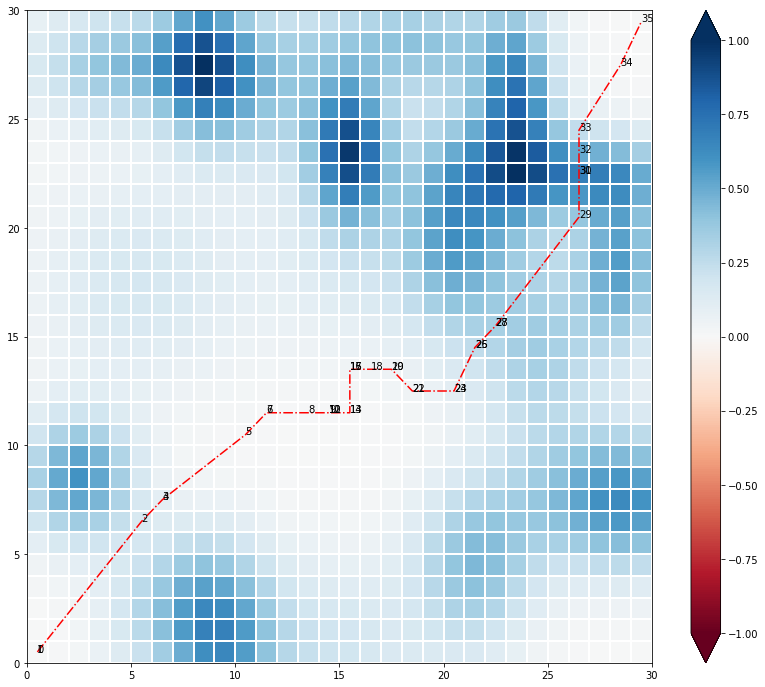

In [99]:
plotField(A, np.array(log_Radius[6][2]))

In [102]:
path_weight(A, log_Radius[6][0], log_Radius[6][2])

91.94631959846863

In [145]:
weight_from_radius_100 = []
weight_from_radius_5 = []
for log in log_Radius:
    if(log[1] < 100):
        if(log[0] == 100):
            weight_from_radius_100.append([log[1], path_weight(A, log[0], log[2])])
        if(log[0] == 5):
            weight_from_radius_5.append([log[1], path_weight(A, log[0], log[2])])

In [144]:
weight_from_K_100 = []
weight_from_K_10 = []
for log in log_K:
    if(log[0] < 100):
        if(log[1] == 100):
            weight_from_K_100.append([log[0], path_weight(A, log[0], log[2])])
        if(log[1] == 10):
            weight_from_K_10.append([log[0], path_weight(A, log[0], log[2])])

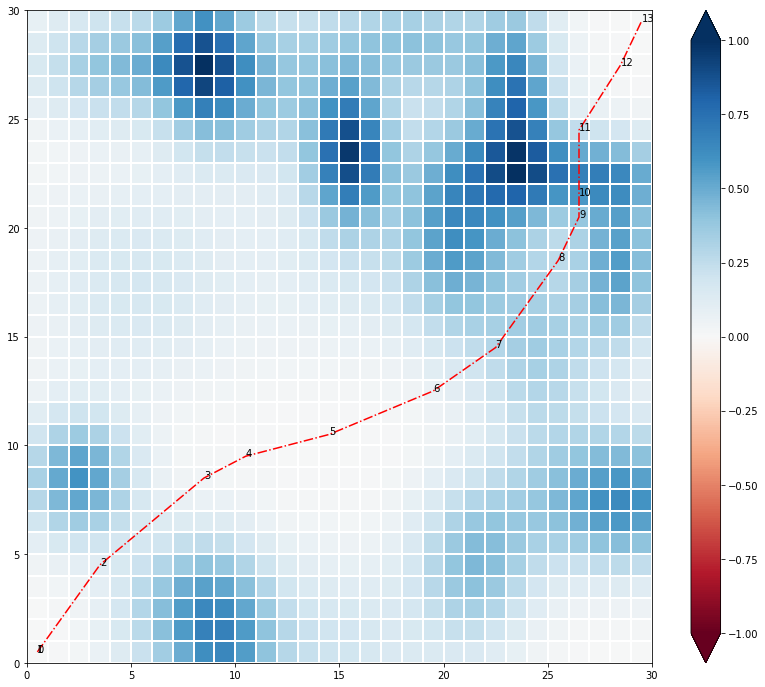

In [178]:
plotField(A, np.array(log_K[9][2]))

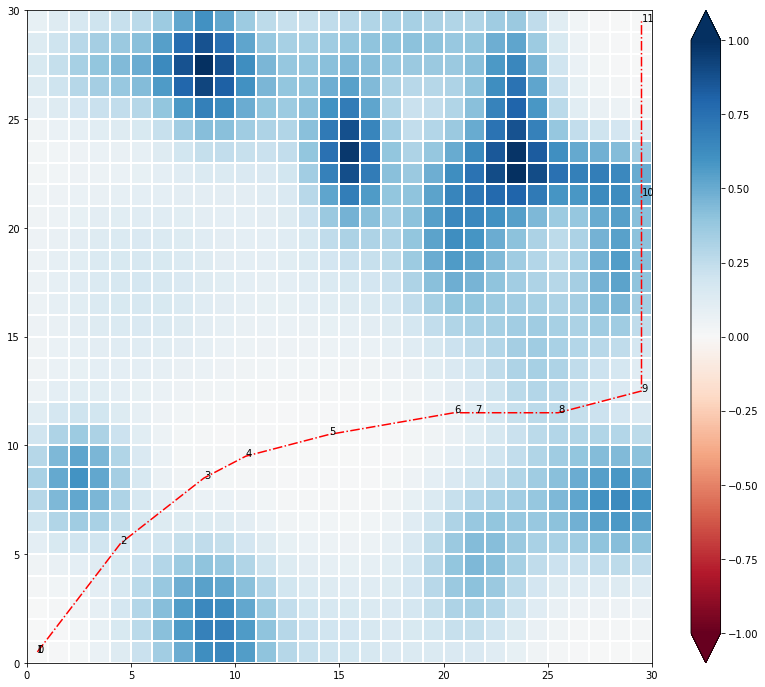

In [175]:
plotField(A, np.array(log_K[11][2]))

In [158]:
weight_from_K_100

[[1, 51.38287616028468],
 [4, 76.57775812610974],
 [7, 101.23003643133596],
 [10, 125.88231473656214],
 [13, 150.51518456807767],
 [16, 173.8986706072489],
 [19, 197.13564022177067],
 [22, 220.3485602066201]]

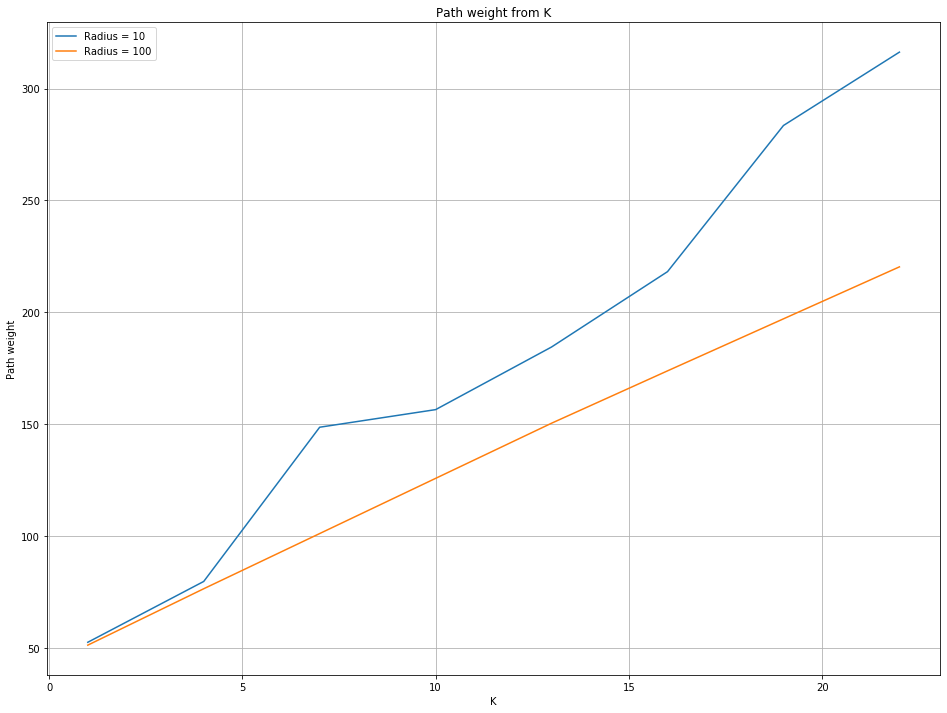

In [157]:
plt.figure(figsize=(16, 12))
plt.plot(np.array(weight_from_K_10)[:,0], np.array(weight_from_K_10)[:,1], label='Radius = 10')
plt.plot(np.array(weight_from_K_100)[:,0], np.array(weight_from_K_100)[:,1], label='Radius = 100')
plt.title("Path weight from K")
plt.xlabel('K')
plt.ylabel('Path weight')
plt.grid()
plt.legend()

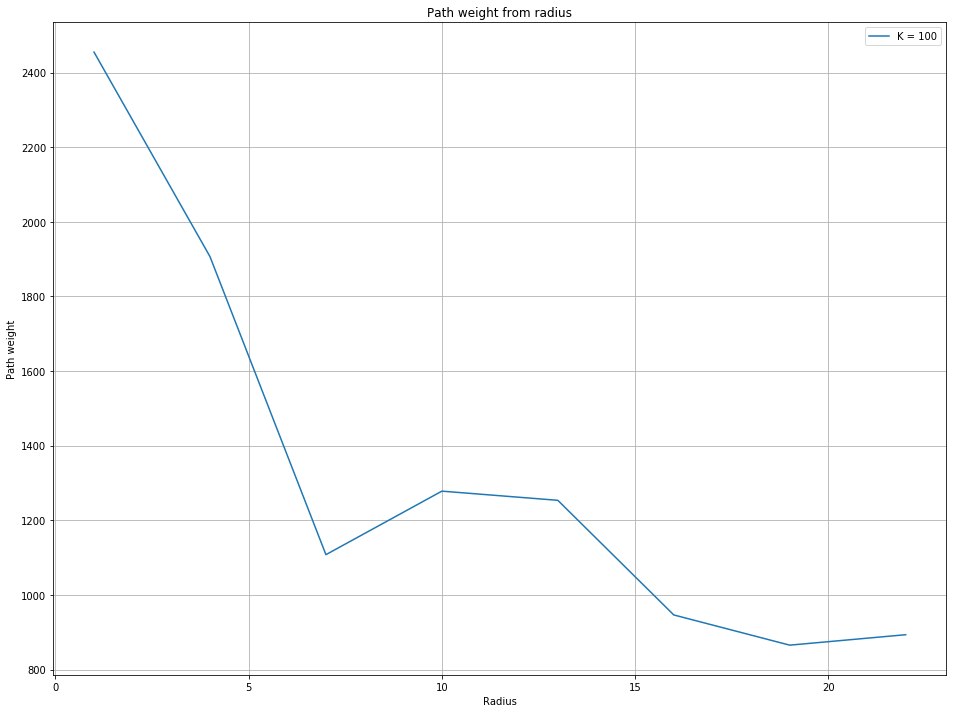

In [184]:
plt.figure(figsize=(16, 12))
plt.plot(np.array(weight_from_radius_100)[:,0], np.array(weight_from_radius_100)[:,1], label='K = 100')
plt.title("Path weight from radius")
plt.xlabel('Radius')
plt.ylabel('Path weight')
plt.grid()
plt.legend()

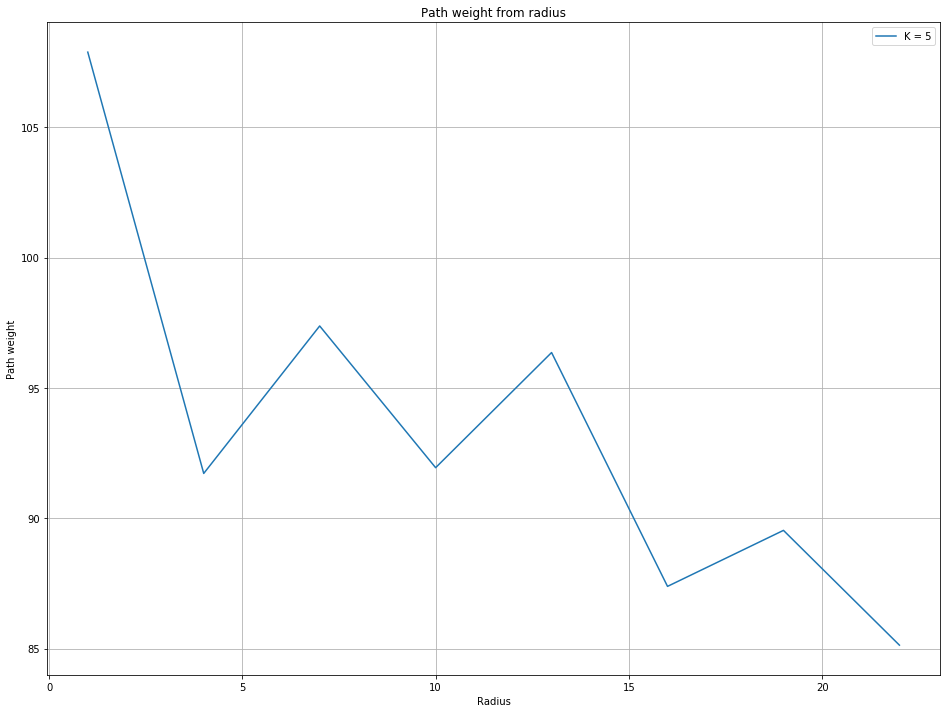

In [183]:
plt.figure(figsize=(16, 12))
plt.plot(np.array(weight_from_radius_5)[:,0], np.array(weight_from_radius_5)[:,1], label='K = 5')
plt.title("Path weight from radius")
plt.xlabel('Radius')
plt.ylabel('Path weight')
plt.grid()
plt.legend()

In [194]:
log_Radius[0]

[5,
 1,
 [[0, 0],
  [0, 0],
  [1, 1],
  [2, 2],
  [3, 3],
  [4, 4],
  [5, 5],
  [6, 6],
  [7, 7],
  [10, 10],
  [13, 13],
  [16, 16],
  [19, 19],
  [19, 19],
  [19, 19],
  [19, 22],
  [20, 24],
  [22, 25],
  [22, 25],
  [24, 25],
  [29, 29]]]

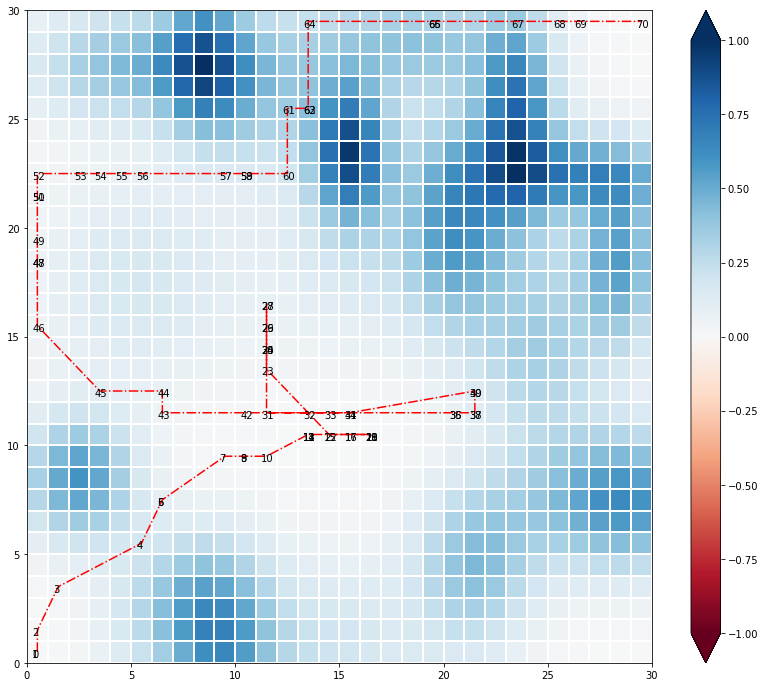

In [197]:
plotField(A, np.array(log_Radius[7][2]))

In [205]:
log_Radius[0]

[5,
 1,
 [[0, 0],
  [0, 0],
  [1, 1],
  [2, 2],
  [3, 3],
  [4, 4],
  [5, 5],
  [6, 6],
  [7, 7],
  [10, 10],
  [13, 13],
  [16, 16],
  [19, 19],
  [19, 19],
  [19, 19],
  [19, 22],
  [20, 24],
  [22, 25],
  [22, 25],
  [24, 25],
  [29, 29]]]

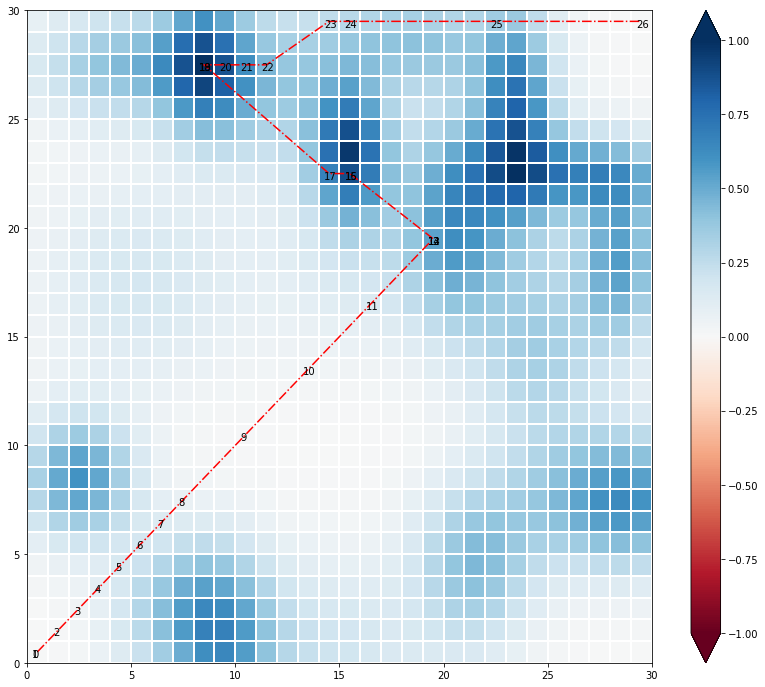

In [207]:
plotField(A, np.array(log_Radius[1][2]))